In [4]:
# import some libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # operating system control
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt # graphing
from mpl_toolkits import mplot3d #matplot toolkit
import PIL as pil #Python Image Library
import re #regedit
from skimage import color
from skimage import io # in and out functions from a second image access library
from skimage import measure # Used to define the marching cubes algorithm
from skimage.transform import rotate # Used to rotate volumes
from skimage.transform import rescale # Used to adjust volume dimensions
import plotly.graph_objects as go #plotly image library

# CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torchvision
from torchvision import transforms

# CNN eval
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

# I. Making a Custom Dataset

In [5]:
# creates a custom dataset out of the given files
class VolumesDataset(torch.utils.data.Dataset): #torch.utils.data.Dataset
    def __init__(self, data, transform=None, train=False, split_ratio=None):
        bug_type = "BugType"
        self.train= train
        self.split_ratios = split_ratio
        self.train_indices = None
        self.val_indices = None
        self.labels = None
        self.transform = transform
        self.data = data 

        # process the training dataset
        if self.train:
            def balanced(data, ix_train):
                """Balances the given dataset's training data"""
                df = data.copy()
                bug_types = list(data.groupby(bug_type).groups.values()) # indices of each bug type
                num_types = len(bug_types) # number of bug types
                # interpolate bugtypes
                for i in range(num_types):
                    bug_type_ix = np.arange(i, ix_train, num_types) # interpolated indices
                    bug_df = data.loc[bug_types[i]]
                    if bug_df.shape[0] < len(bug_type_ix):
                        bug_type_ix = bug_type_ix[:bug_df.shape[0]]
                    df.loc[bug_type_ix, :] = bug_df.iloc[:len(bug_type_ix)].set_index(bug_type_ix) # assign bug type to interpolated indices
                return df

            # balance the training data
            if self.split_ratios:
                tot = data.shape[0] # number of observations
                train_samples = int(split_ratio[0] * tot) 
                val_samples = int(split_ratio[1] * tot) 
                self.train_indices = np.arange(0, train_samples) # training data
                self.val_indices = np.arange(train_samples, train_samples + val_samples) # validation data
    
                # interpolate the bugs across the dataset to ensure trainingset is balanced
                if split_ratio[0] > 0:
                    self.data = balanced(data, train_samples)
            else:
                print("Please provide the training/validation split ratios.")

            # create the training data labels
            def create_labels(data):
                """Creates the labels for the given dataset"""
                labels = data.BugType.replace(dict(zip(data.BugType.unique(), range(data.BugType.nunique())))).values
                return labels
            
            self.labels = create_labels(self.data) 

    def __len__(self):
        if self.train:
            return self.data.shape[0]
        else:
            # test sets will always be 1 file long
            return 1

    def __getitem__(self, idx):
        if self.train:
            img = self.data.FileLoc.iloc[idx]
            if self.transform:
                img = self.transform(img)
            label = self.labels[idx]
            return img, torch.tensor(label)
        else:
            img = self.data
            img = self.transform(img)
            return img

In [6]:
# read in the data
def read_tif_file(fp):
    '''Read and load the volume'''
    # read file
    im = io.imread(fp)
    return im.astype("float32")
    
# resize the volume to 128 * 64 * 64
def resize_volume(im):
    # set desired dims
    desired_depth = 128 
    desired_width = 64
    desired_height = 64
    # get current dims
    curr_depth = im.shape[0]
    curr_width = im.shape[1]
    curr_height = im.shape[2]
    # compute dims factor
    depth_factor = desired_depth / curr_depth
    width_factor = desired_width / curr_width
    height_factor = desired_height / curr_height
    # resize across z-axis
    im = rescale(im, (depth_factor, width_factor, height_factor), order=1)
    return im

# downsample the 3D volume
def downsample_volume(im, block_size=10):
    im = measure.block_reduce(im, block_size=block_size, func=np.mean)
    return im

# pre-processing pipeline that resizes and downsamples
def process_vol(fp):
    if type(fp) == str:
        img = read_tif_file(fp) # read in the filepath
    else:
        img = fp # work with the 3D np array
    img = resize_volume(img)
    img = downsample_volume(img)
    return img

transform_with_unsqueeze = transforms.Compose([
    transforms.Lambda(lambda img: process_vol(img)),
    transforms.Lambda(lambda img: torch.from_numpy(img)),  # Convert to PyTorch tensor
    transforms.Lambda(lambda img: torch.unsqueeze(img, dim=0).repeat(3, 1, 1, 1)) 
])

In [7]:
# TODO: downsampling to make the depth, width and height smaller -> https://stackoverflow.com/questions/18666014/downsample-array-in-python
# goal: decrease compute
# goal: get validation performance on FULL validation set

# II. Building the Model

In [8]:
# define the 3D CNN
num_classes = 12

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(128, 64) 
        self.relu = nn.LeakyReLU()
        self.drop=nn.Dropout(p=0.50)
        self.classifier = nn.Linear(64, num_classes)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(2, 2, 2), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.drop(out)
        out = self.conv_layer2(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.classifier(out)
        
        return out

#Definition of hyperparameters
num_epochs = 50

# Create CNN
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel() #.to(device)

#model.cuda()
print(model)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=64, out_features=12, bias=True)
)


# III. Training the Model

## Loading in the training data

In [9]:
def make_dataset(df, transforms=transform_with_unsqueeze, train=False, splits=None):
    dataset = VolumesDataset(df.reset_index(), transform=transforms, train=train, split_ratio=splits)
    return dataset

In [10]:
def load_data(dataset, indices=None, train_batch_size=None):
    if indices is None:
        return torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    else:
        return torch.utils.data.DataLoader(dataset, sampler=SubsetRandomSampler(indices), batch_size=train_batch_size)

In [ ]:
os.getcwd()

In [23]:
# read in the dataset
root = '/home/dfabella/Debuggers/'
train_fp = root + "BugNIST_DATA/custom_train"
A = []

bug_labels = {'AC' : 'Brown Cricket', 'BC' : 'Black Cricket', 'BF' : 'Blow fly', 
              'BL' : 'Buffalo Beetle Larva' , 'BP' : 'Blow Fly Pupa', 'CF' : 'Curly-wing Fly', 'GH' : 'Grasshopper',
              'MA' : 'Maggot', 'ML' : 'Mealworm', 'PP' : 'Green Bottle Fly Pupa' , 'SL' : 'Soldier Fly Larva',
              'WO' : 'Woodlice'}

for i, v in bug_labels.items():
    for fp in os.listdir(train_fp +'/' + i):
        tif_fp = train_fp + '/' + i + '/' + fp
        try:
            io.imread(tif_fp)
        except OSError as err:
            print(f"{OSError}: Can't read in filepath '{tif_fp}'")
        else:
            A.append({'FileLoc' : tif_fp, 'BugType' : i})

# make training dataframe
df_train = pd.DataFrame(A)
subset = 0.9
df_train = df_train.sample(int(df_train.shape[0] * subset))

# preprocessing data
train_split = 0.8
val_split = 0.2
dataset = make_dataset(df_train, train=True, splits=(train_split, val_split))

# creating "generator" for training and validation data
batch_size64 = 64
train_loader = load_data(dataset, dataset.train_indices, batch_size64)
val_loader = load_data(dataset, dataset.val_indices, batch_size64)

<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/AC/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/BC/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/BF/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/BL/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/BP/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/CF/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/GH/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/MA/.DS_Store'
<class 'OSError'>: Can't read in filepath '/home/dfabella/Debuggers/BugNIST_DATA/custom_train/ML/.DS_Store'
<class 'OSError'>: Can't rea

In [24]:
df_train.shape

(8238, 2)

In [25]:
%%time
foo = iter(train_loader)
next(foo)[0].shape # [batch_size, channels, depth, height, width] -> [__, 3, 128/block_size, 64/block_size, 64/block_size]

CPU times: user 2.95 s, sys: 34.9 ms, total: 2.99 s
Wall time: 2.99 s


torch.Size([64, 3, 13, 7, 7])

In [102]:
%%time
# CNN model training
count = 0
loss_list = []
preds_list = []
accuracy_list = []
curr_ac = 0
for epoch in range(num_epochs):
    if curr_ac >= 80: # naive stopping mechanism
        break
    for i, (images, labels) in enumerate(train_loader):
        
        train = images
        labels = labels
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 2 == 0:
            print(f"loading... {count}")
        if True:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through val dataset
            for images, labels in val_loader:
                
                test = images
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            curr_acc = accuracy
            
            # store loss and iteration
            loss_list.append(loss.data)
            preds_list.append(predicted)
            accuracy_list.append(accuracy)

        if count % 10 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


loading... 2
loading... 4
loading... 6
loading... 8
loading... 10
Iteration: 10  Loss: 2.4703335762023926  Accuracy: 7.832422733306885 %
loading... 12
loading... 14
loading... 16
loading... 18
loading... 20
Iteration: 20  Loss: 2.476435899734497  Accuracy: 6.921675682067871 %
loading... 22
loading... 24
loading... 26
loading... 28
loading... 30
Iteration: 30  Loss: 2.4807288646698  Accuracy: 8.075288772583008 %
loading... 32
loading... 34
loading... 36
loading... 38
loading... 40
Iteration: 40  Loss: 2.4786593914031982  Accuracy: 7.832422733306885 %
loading... 42
loading... 44
loading... 46
loading... 48
loading... 50
Iteration: 50  Loss: 2.489863872528076  Accuracy: 7.5288405418396 %
loading... 52
loading... 54
loading... 56
loading... 58
loading... 60
Iteration: 60  Loss: 2.4880542755126953  Accuracy: 7.589556694030762 %
loading... 62
loading... 64
loading... 66
loading... 68
loading... 70
Iteration: 70  Loss: 2.476608991622925  Accuracy: 7.589556694030762 %
loading... 72
loading... 

OSError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`

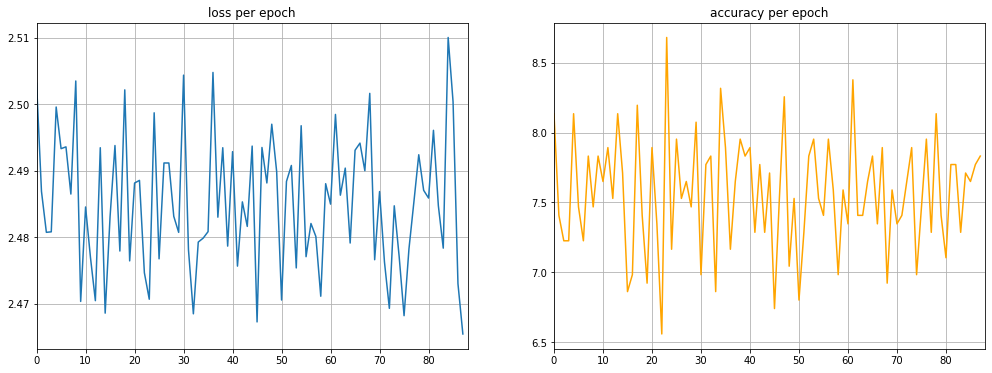

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
axs[0].plot(loss_list)
axs[0].set_title("loss per epoch")
axs[1].plot(accuracy_list, color="orange")
axs[1].set_title("accuracy per epoch")

for ax in axs:
    ax.grid(True)
    ax.set_xlim(0, len(loss_list))

# III. Saving the Model

In [110]:
# saving the model then loading it in
PATH = root+'/models'
torch.save(model, PATH)
saved_model = torch.load(PATH)
# eval(saved_model, test_loader)

# IV. Building the Pipeline

In [113]:
# Make predicitons
def make_preds(model_path, data_loader):
    # load in the model
    model = torch.load(model_path)
    make predictions
    preds = []
    labels = []
    for img, label in data_loader:
        with torch.no_grad():
            out = model(img)
            pred = torch.argmax(out)
            preds.append(pred)
            labels.append(label[0])
    return np.array(preds), np.array(labels)

# Evaluate model
def eval_model(preds, labels, plot_cm=True):
    acc = "acc"
    prec = "prec"
    rec = "rec"
    # TODO: map bug int label to bug str label
    for bug in bugs:
        # bug's predictions
        bi_labels = labels == bug 
        bi_preds = preds == bug
        # bug's truth tables
        cm = confusion_matrix(bi_labels, bi_preds)
        if plot_cm:
            cm_norm = cm/len(preds)
            c_names = ['True Neg','False Pos','False Neg','True Pos']
            c_counts = cm.flatten()
            c_percentages = ["{0:.2%}".format(value) for value in cm_norm.flatten()]
            table_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(c_names,c_counts,c_percentages)]
            table_labels = np.asarray(table_labels).reshape(2,2)
            s = sn.heatmap(cm_norm, annot=table_labels, fmt='', cmap='Blues')
            s.set(xlabel="Predicted", ylabel="True", title=f"{bug} True Table")
            plt.show()
        tn, fp, fn, tp = cm.ravel()
        # bug's performance metrics
        bug_metrics[bug] = dict.fromkeys([acc, prec, rec], 0)
        bug_metrics[bug][acc] = (tp + tn) / (tp + fp + fn + tn)
        bug_metrics[bug][prec] = tp / (tp + fp)
        bug_metrics[bug][rec] = tp / (tp + fn)

    # model performance
    model_metrics = dict.fromkeys([acc, prec, rec], 0)
    model_metrics[acc] = (labels == preds).mean()
    return model_metrics,bug_metrics

# Model evaluation pipeline
def run_eval_model(model_path, data_loader, plot_cm=True):
    make_preds(model_path, data_loader)
    model_metrics, bug_metrics = eval_model(preds, labels, plot_cm=plot_cm)
    return model_metrics, bug_metrics

In [ ]:
# we will see it's performance on the remaining .tif files
test_dataset = make_dataset(df_train)
test_loader = load_data(test_dataset)
model_path = PATH
model_preds = make_preds(model_path, test_loader)

In [114]:
model_metrics, bug_metrics = run_eval_model(model_path, test_loader, plot_cm=False)

OSError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`

In [122]:
(np.array(preds) == np.array(labels)).mean()

0.08016550297388156

In [ ]:
# make_preds(PATH, train_loader_set)

In [ ]:
# model_metrics, bug_metrics